# Load checkpoint and imports

In [1]:
device_name='cuda'
parent_dir = "/Midgard/home/farzantn/phd/Olfaction/molformer-main"
import sys
import os
sys.path.append(parent_dir)
parent_dir="/Midgard/home/farzantn/mambaforge/envs/MolTran_CUDA11_cuda/lib/python3.8"
sys.path.append(parent_dir)
import ast
from ast import literal_eval

from datetime import datetime
from argparse import Namespace
import yaml
from tokenizer.tokenizer import MolTranBertTokenizer
from openpom.utils.data_utils import get_class_imbalance_ratio
with open('../../data/Pretrained MoLFormer/hparams.yaml', 'r') as f:
    config = Namespace(**yaml.safe_load(f))
from train_pubchem_light import LightningModule
import seaborn as sns
from utils.util_alignment import *
from utils.prepare_datasets import *
from utils.custom_models import *
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 25
plt.rcParams["figure.figsize"] = (10,10)
plt.rc('font',**{'family':'serif','serif':['Times']})

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/Midgard/home/farzantn/mambaforge/envs/Mol/lib/python3.8/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading some Jax models, missing a dependency. No module named 'jax'


# Loading Models

## Loading MolFormer Model

In [2]:
tokenizer = MolTranBertTokenizer('bert_vocab.txt')
ckpt = '../../data/Pretrained MoLFormer/checkpoints/N-Step-Checkpoint_3_30000.ckpt'
lm = LightningModule(config, tokenizer.vocab).load_from_checkpoint(ckpt, config=config, vocab=tokenizer.vocab)

Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


Global seed set to 12345


Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


Global seed set to 12345


In [3]:
def create_linear_classifier(TASKS, n_classes,dataset,mode="classification"):
    n_classes = 1
    n_tasks= len(TASKS)
    if mode == "classification":
        model = NonLinearModel(n_tasks).to(device_name)
    elif mode== "regression":
        model = LinearModelRegression(n_tasks).to(device_name)
    # model.n_tasks=n_tasks
    model.n_classes=1
    train_ratios = get_class_imbalance_ratio(dataset)
    # ratios = get_class_imbalance_ratio(train_dataset)
    lr = 1e-4
    
    learning_rate = 0.001
    modeldeepchem = LinearModelMultiLabelDeepchem(\
        model=model,class_imbalance_ratio=train_ratios,loss_aggr_type='sum',\
        device_name=device_name,mode=mode,optimizer_name = 'adam',\
        learning_rate=learning_rate,batch_size=128)
    
    return modeldeepchem
    

In [4]:
def run_linear_classifier(modeldeepchem,embedding_dataset,embedding_test_dataset,metric,metric_str,nb_epoch = 2):
    start_time = datetime.now()
    
    train_scores=[]
    valid_scores=[]
    losses=[]
    for epoch in range(1, nb_epoch+1):
        loss = modeldeepchem.fit(
              embedding_dataset,
              nb_epoch=1,
              max_checkpoints_to_keep=1,
              deterministic=False,
              restore=epoch>1)
        # train_score = modeldeepchem.evaluate(embedding_dataset, [metric])[metric_str]
        # valid_score = modeldeepchem.evaluate(embedding_test_dataset, [metric])[metric_str]
        # # print(f"epoch {epoch}/{nb_epoch} ; loss = {loss}; train_scores = {train_score}; valid_scores = {valid_score}")
        # train_scores.append(train_score)
        # valid_scores.append(valid_score)
        losses.append(loss)
        # print(epoch)
    
    modeldeepchem.save_checkpoint()
    end_time = datetime.now()
    return modeldeepchem,train_scores,valid_scores,losses


In [5]:
def prepare_dataset(ds):
    ds['y'] = ds['y'].apply(ast.literal_eval)
    ds['embeddings'] = ds['embeddings'].apply(ast.literal_eval)
    return ds

In [6]:
# input_file = '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/curated_datasets/mols_datasets/curated_ravia2020_behavior_similairity.csv'
# pd.read_csv(input_file)

# Loading Human Embeddings

## Ravia 2020 Similarity

In [7]:
df_ravia,df_ravia_similarity_mean, df_ravia_similarity_mean_pivoted=prepare_ravia()

Index(['CID Stimulus 1', 'CID Stimulus 2', 'RatedSimilarity',
       'Stimulus 1-IsomericSMILES', 'Stimulus 2-IsomericSMILES',
       'Stimulus 1-IsomericSMILES_sep', 'Stimulus 2-IsomericSMILES_sep',
       'Stimulus 1-nonStereoSMILES', 'Stimulus 2-nonStereoSMILES',
       'Stimulus 1-nonStereoSMILES_sep', 'Stimulus 2-nonStereoSMILES_sep'],
      dtype='object')


## Snitz 2013

In [8]:
df_snitz, df_snitz_mean,df_snitz_mean_pivoted=prepare_snitz()

# Extracting embedding from MoLFormer

## Extracting embedding from MoLFormer for GS-LF and training a (Linear?) Layer on that

In [9]:
 
gs_lf_tasks = [
'alcoholic', 'aldehydic', 'alliaceous', 'almond', 'amber', 'animal',
'anisic', 'apple', 'apricot', 'aromatic', 'balsamic', 'banana', 'beefy',
'bergamot', 'berry', 'bitter', 'black currant', 'brandy', 'burnt',
'buttery', 'cabbage', 'camphoreous', 'caramellic', 'cedar', 'celery',
'chamomile', 'cheesy', 'cherry', 'chocolate', 'cinnamon', 'citrus', 'clean',
'clove', 'cocoa', 'coconut', 'coffee', 'cognac', 'cooked', 'cooling',
'cortex', 'coumarinic', 'creamy', 'cucumber', 'dairy', 'dry', 'earthy',
'ethereal', 'fatty', 'fermented', 'fishy', 'floral', 'fresh', 'fruit skin',
'fruity', 'garlic', 'gassy', 'geranium', 'grape', 'grapefruit', 'grassy',
'green', 'hawthorn', 'hay', 'hazelnut', 'herbal', 'honey', 'hyacinth',
'jasmin', 'juicy', 'ketonic', 'lactonic', 'lavender', 'leafy', 'leathery',
'lemon', 'lily', 'malty', 'meaty', 'medicinal', 'melon', 'metallic',
'milky', 'mint', 'muguet', 'mushroom', 'musk', 'musty', 'natural', 'nutty',
'odorless', 'oily', 'onion', 'orange', 'orangeflower', 'orris', 'ozone',
'peach', 'pear', 'phenolic', 'pine', 'pineapple', 'plum', 'popcorn',
'potato', 'powdery', 'pungent', 'radish', 'raspberry', 'ripe', 'roasted',
'rose', 'rummy', 'sandalwood', 'savory', 'sharp', 'smoky', 'soapy',
'solvent', 'sour', 'spicy', 'strawberry', 'sulfurous', 'sweaty', 'sweet',
'tea', 'terpenic', 'tobacco', 'tomato', 'tropical', 'vanilla', 'vegetable',
'vetiver', 'violet', 'warm', 'waxy', 'weedy', 'winey', 'woody'
]

base_path= '../../../../../../T5 EVO/'


In [10]:
input_file_molformer = '/local_storage/datasets/user/alignment_olfaction_datasets/curated_datasets/embeddings/molformer/ravia_molformer_embeddings_13_Apr17.csv'
gs_lf_molformer=pd.read_csv(input_file_molformer)
gs_lf_molformer['embeddings'] = gs_lf_molformer['embeddings'].apply(ast.literal_eval)
# gs_lf_molformer=prepare_dataset(gs_lf_molformer)
len(gs_lf_molformer['embeddings'].tolist())
# df_mols_embeddings_original = 

350

In [11]:
input_file_molformer = '/local_storage/datasets/user/alignment_olfaction_datasets/curated_datasets/embeddings/molformer/gslf_molformer_embeddings_13_Apr17.csv'
input_file_indices = '/local_storage/datasets/user/alignment_olfaction_datasets/curated_datasets/embeddings/pom/gslf-splits-idx.csv' # or new downloaded file path
indices = pd.read_csv(input_file_indices)
indices_train = indices.loc[indices['split']=='train']['main_idx'].values.tolist()
indices_valid = indices.loc[indices['split']=='valid']['main_idx'].values.tolist()
indices_test = indices.loc[indices['split']=='test']['main_idx'].values.tolist()


gs_lf_molformer=pd.read_csv(input_file_molformer)
gs_lf_molformer=prepare_dataset(gs_lf_molformer)


gs_lf_molformer_np = np.asarray(gs_lf_molformer.embeddings.tolist())
gs_lf_molformer_y = np.asarray(gs_lf_molformer.y.tolist())
gs_lf_molformer_embeddings_train = gs_lf_molformer_np[indices_train]
gs_lf_molformer_y_train = gs_lf_molformer_y[indices_train]

gs_lf_molformer_embeddings_test = gs_lf_molformer_np[indices_test]
gs_lf_molformer_y_test = gs_lf_molformer_y[indices_test]

gs_lf_molformer_embeddings_valid = gs_lf_molformer_np[indices_valid]
gs_lf_molformer_y_valid = gs_lf_molformer_y[indices_valid]

embedding_train_dataset_gslf = dc.data.DiskDataset.from_numpy(gs_lf_molformer_embeddings_train,gs_lf_molformer_y_train)
embedding_test_dataset_gslf = dc.data.DiskDataset.from_numpy(gs_lf_molformer_embeddings_test,gs_lf_molformer_y_test)
embedding_valid_dataset_gslf = dc.data.DiskDataset.from_numpy(gs_lf_molformer_embeddings_valid,gs_lf_molformer_y_valid)

dataset_gslf = dc.data.DiskDataset.from_numpy(gs_lf_molformer_np,gs_lf_molformer_y)

In [12]:

modeldeepchem_gslf =  create_linear_classifier(gs_lf_tasks, 1,dataset_gslf)
metric_gslf = dc.metrics.Metric(dc.metrics.roc_auc_score)

modeldeepchem_gslf,train_scores_gslf,test_scores_gslf,losses_gslf= run_linear_classifier(modeldeepchem_gslf,embedding_train_dataset_gslf,embedding_test_dataset_gslf,metric_gslf,'roc_auc_score',nb_epoch = 100)

# Computing Similarity Values

### Dataset Statistics

In [13]:
# ravia_mean=df_ravia_similarity_mols['nonStereoSMILES'].apply(len).mean()
# ravia_std=df_ravia_similarity_mols['nonStereoSMILES'].apply(len).std()
# ravia_max=df_ravia_similarity_mols['nonStereoSMILES'].apply(len).max()
# ravia_min=df_ravia_similarity_mols['nonStereoSMILES'].apply(len).min()
# print(ravia_min, ravia_max, ravia_mean, ravia_std)

## Ravia2020 similarity MoLFormer

In [14]:
df_ravia_similarity_mols,df_ravia_similarity_mols_embeddings_original,df_ravia_similarity_mols_layers_original\
,df_ravia_similarity_mols_embeddings,df_ravia_similarity_mols_embeddings_zscored,\
df_ravia_similarity_mols_layers,df_ravia_similarity_mols_layers_zscored,df_ravia_similarity_mols_embeddings_linear\
,df_ravia_similarity_mols_embeddings_linear_zscored=prepare_ravia_similarity_mols2(df_ravia_similarity_mean,modeldeepchem_gslf,lm,tokenizer)

### Cosine Similarity

In [15]:
cosine_sim_df_ravia_similarity_mols_embeddings,cosine_sim_df_ravia_similarity_mols_embeddings_zscored,cosine_sim_df_ravia_similarity_mols_layers,cosine_sim_df_ravia_similarity_mols_layers_zscored,cosine_sim_df_ravia_similarity_mols_embeddings_linear,cosine_sim_df_ravia_similarity_mols_embeddings_linear_zscored\
=cosine_sim_helper(df_ravia_similarity_mols_embeddings,df_ravia_similarity_mols_embeddings_zscored,df_ravia_similarity_mols_layers,df_ravia_similarity_mols_layers_zscored,df_ravia_similarity_mols_embeddings_linear,df_ravia_similarity_mols_embeddings_linear_zscored)

## Ravia2020 similarity OpenPom

In [16]:
input_file_pom='/local_storage/datasets/user/alignment_olfaction_datasets/curated_datasets/embeddings/pom/ravia_pom_embeddings_Apr17.csv'

df_ravia_similarity_mols_pom,df_ravia_similarity_mols_embeddings_original_pom\
,df_ravia_similarity_mols_embeddings_pom,df_ravia_similarity_mols_embeddings_zscored_pom\
=prepare_ravia_similarity_mols_mixture(input_file_pom, df_ravia_similarity_mean,modeldeepchem_gslf)

### Cosine Similarity

In [17]:
cosine_sim_df_ravia_similarity_mols_embeddings_pom,cosine_sim_df_ravia_similarity_mols_embeddings_zscored_pom\
=cosine_sim_helper_mixture(df_ravia_similarity_mols_embeddings_pom,df_ravia_similarity_mols_embeddings_zscored_pom)

## Ravia2020 similarity DAM

In [22]:
input_file_alva='/local_storage/datasets/user/alignment_olfaction_datasets/curated_datasets/alva/ravia_molecules_alva_17Apr.csv'

df_ravia_similarity_mols_alva,df_ravia_similarity_mols_embeddings_original_alva\
,df_ravia_similarity_mols_embeddings_alva,df_ravia_similarity_mols_embeddings_zscored_alva\
=prepare_mols_DAM(input_file_alva,df_ravia_similarity_mean,modeldeepchem_gslf)

In [23]:
cosine_sim_df_ravia_similarity_mols_embeddings_alva,cosine_sim_df_ravia_similarity_mols_embeddings_zscored_alva\
=cosine_sim_helper_mixture(df_ravia_similarity_mols_embeddings_alva,df_ravia_similarity_mols_embeddings_zscored_alva)

## Snitz 2013 MoLFromer

In [24]:
# df_snitz_mols['nonStereoSMILES']
# snitz_mean=df_snitz_mols['nonStereoSMILES'].apply(len).mean()
# snitz_std=df_snitz_mols['nonStereoSMILES'].apply(len).std()
# snitz_max=df_snitz_mols['nonStereoSMILES'].apply(len).max()
# snitz_min=df_snitz_mols['nonStereoSMILES'].apply(len).min()
# print(snitz_min, snitz_max, snitz_mean, snitz_std)

In [25]:
df_snitz_mols,df_snitz_mols_embeddings_original,df_snitz_mols_layers_original,\
df_snitz_mols_embeddings,df_snitz_mols_embeddings_zscored,\
df_snitz_mols_layers,df_snitz_mols_layers_zscored,df_snitz_mols_embeddings_linear,\
df_snitz_mols_embeddings_linear_zscored=prepare_snitz_mols(df_snitz_mean,modeldeepchem_gslf,lm,tokenizer)

In [26]:
# df_snitz_mols_embeddings_linear

### Dataset Statistics

### Cosine Similarity

In [27]:
cosine_sim_df_snitz_mols_embeddings,cosine_sim_df_snitz_mols_embeddings_zscored,cosine_sim_df_snitz_mols_layers,cosine_sim_df_snitz_mols_layers_zscored,cosine_sim_df_snitz_mols_embeddings_linear,cosine_sim_df_snitz_mols_embeddings_linear_zscored \
=cosine_sim_helper(df_snitz_mols_embeddings,df_snitz_mols_embeddings_zscored,df_snitz_mols_layers,df_snitz_mols_layers_zscored,df_snitz_mols_embeddings_linear,df_snitz_mols_embeddings_linear_zscored)

## Snitz 2013 OpenPom

In [28]:
input_file_pom_snitz='/local_storage/datasets/farzaneh/alignment_olfaction_datasets/curated_datasets/embeddings/pom/snitz_pom_embeddings_Apr17.csv'
# pd.read_csv(input_file_pom_snitz)

In [29]:
df_snitz_mols_pom,df_snitz_mols_embeddings_original_pom,df_snitz_mols_embeddings_pom,df_snitz_mols_embeddings_zscored_pom=prepare_mols_other(input_file_pom_snitz, df_snitz_mean,modeldeepchem_gslf)

### Cosine Similarity

In [30]:
# df_snitz_mols_embeddings_pom.CID.values.tolist()

In [31]:
# cosine_sim_df_snitz_mols_embeddings_pom,cosine_sim_df_snitz_mols_embeddings_zscored_pom,cosine_sim_df_snitz_mols_layers,cosine_sim_df_snitz_mols_layers_zscored,cosine_sim_df_snitz_mols_embeddings_linear,cosine_sim_df_snitz_mols_embeddings_linear_zscored \
# =cosine_sim_helper(df_snitz_mols_embeddings,df_snitz_mols_embeddings_zscored,df_snitz_mols_layers,df_snitz_mols_layers_zscored,df_snitz_mols_embeddings_linear,df_snitz_mols_embeddings_linear_zscored)


cosine_sim_df_snitz_mols_embeddings_pom,cosine_sim_df_snitz_mols_embeddings_zscored_pom\
=cosine_sim_helper_mixture(df_snitz_mols_embeddings_pom,df_snitz_mols_embeddings_zscored_pom)

In [32]:
# df_snitz_mols_embeddings_pom

## Snitz 2013 Alva

In [33]:
input_file_alva='/local_storage/datasets/user/alignment_olfaction_datasets/curated_datasets/alva/snitz_molecules_alva_17Apr.csv'

df_snitz_mols_alva,df_snitz_mols_embeddings_original_alva\
,df_snitz_mols_embeddings_alva,df_snitz_mols_embeddings_zscored_alva\
=prepare_mols_DAM(input_file_alva,df_snitz_mean,modeldeepchem_gslf,sep=',')

In [34]:
cosine_sim_df_snitz_mols_embeddings_alva,cosine_sim_df_snitz_mols_embeddings_zscored_alva\
=cosine_sim_helper_mixture(df_snitz_mols_embeddings_alva,df_snitz_mols_embeddings_zscored_alva)

## Goodscent - Leffignwell

In [35]:
df_gslf_mols,df_gslf_mols_embeddings_original,df_gslf_mols_layers_original,df_gslf_mols_embeddings,df_gslf_mols_embeddings_zscored,df_gslf_mols_layers,df_gslf_mols_layers_zscored,df_gslf_mols_embeddings_linear,df_gslf_mols_embeddings_linear_zscored=prepare_goodscentleffignwell_mols(modeldeepchem_gslf,lm,tokenizer)

### dataset Statistics

In [36]:
# df_snitz_mols['nonStereoSMILES']
gslf_mean=df_gslf_mols['nonStereoSMILES'].apply(len).mean()
gslf_std=df_gslf_mols['nonStereoSMILES'].apply(len).std()
gslf_max=df_gslf_mols['nonStereoSMILES'].apply(len).max()
gslf_min=df_gslf_mols['nonStereoSMILES'].apply(len).min()
print(gslf_min, gslf_max, gslf_mean, gslf_std)

1 189 19.352398153722657 9.263279539157104


In [38]:
input_embeddings='/local_storage/datasets/user/alignment_olfaction_datasets/curated_datasets/embeddings/pom/gslf_pom_embeddings_Apr17.csv'
df_gslf_pom = pd.read_csv(input_embeddings, converters={'embeddings': pd.eval , "y": pd.eval})


# Visualization

In [40]:
def pom_frame(pom_embeds, y, dir,required_desc,title,size1,size2,size3 ):
    sns.set_style("ticks")
    sns.despine()

    # pom_embeds = model.predict_embedding(dataset)
    # y_preds = model.predict(dataset)
    # required_desc = list(dataset.tasks)
    type1 = {'floral': '#F3F1F7', 'subs': {'muguet': '#FAD7E6', 'lavender': '#8883BE', 'jasmin': '#BD81B7'}}
    type2 = {'meaty': '#F5EBE8', 'subs': {'savory': '#FBB360', 'beefy': '#7B382A', 'roasted': '#F7A69E'}}
    type3 = {'ethereal': '#F2F6EC', 'subs': {'cognac': '#BCE2D2', 'fermented': '#79944F', 'alcoholic': '#C2DA8F'}}
        
    # Assuming you have your features in the 'features' array
    pca = PCA(n_components=2, iterated_power=10)  # You can choose the number of components you want (e.g., 2 for 2D visualization)
    reduced_features = pca.fit_transform(pom_embeds) # try different variations

    variance_explained = pca.explained_variance_ratio_

    # Variance explained by PC1 and PC2
    variance_pc1 = variance_explained[0]
    variance_pc2 = variance_explained[1]

    # if is_preds:
    #     y = np.where(y_preds>threshold, 1.0, 0.0) # try quartile range (or rank)
    # else:
    #     y = dataset.y

    # Generate grid points to evaluate the KDE on (try kernel convolution)
    x_grid, y_grid = np.meshgrid(np.linspace(reduced_features[:, 0].min(), reduced_features[:, 0].max(), 500),
                                 np.linspace(reduced_features[:, 1].min(), reduced_features[:, 1].max(), 500))
    grid_points = np.vstack([x_grid.ravel(), y_grid.ravel()])
    def get_kde_values(label):
        plot_idx = required_desc.index(label)
        # print(y[:, plot_idx])
        label_indices = np.where(y[:, plot_idx] == 1)[0]
        kde_label = gaussian_kde(reduced_features[label_indices].T)
        kde_values_label = kde_label(grid_points)
        kde_values_label = kde_values_label.reshape(x_grid.shape)
        return kde_values_label
    
    def plot_contours(type_dictionary, bbox_to_anchor):
        main_label = list(type_dictionary.keys())[0]
        plt.contourf(x_grid, y_grid, get_kde_values(main_label), levels=1, colors=['#00000000',type_dictionary[main_label],type_dictionary[main_label]])
        axes = plt.gca() #Getting the current axis

        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        legend_elements = []
        for label, color in type_dictionary['subs'].items():
            plt.contour(x_grid, y_grid, get_kde_values(label), levels=1, colors=color, linewidths=2)
            legend_elements.append(Patch(facecolor=color, label=label))
        legend = plt.legend(handles=legend_elements, title=main_label, bbox_to_anchor=bbox_to_anchor,prop={'size': 30})
        legend.get_frame().set_facecolor(type_dictionary[main_label])
        plt.gca().add_artist(legend)

    fig=plt.figure(figsize=(15, 15),dpi=700)
    # ax.spines[['right', 'top']].set_visible(False)
    # plt.title('KDE Density Estimation with Contours in Reduced Space')
    # plt.xlabel(f'Principal Component 1 ({round(variance_pc1*100, ndigits=2)}%)')
    # plt.ylabel(f'Principal Component 2 ({round(variance_pc2*100, ndigits=2)}%)')
    plt.xlabel('Principal Component 1',fontsize=35)
    plt.ylabel('Principal Component 2',fontsize=35)
    plot_contours(type_dictionary=type1, bbox_to_anchor = size1)
    plot_contours(type_dictionary=type2, bbox_to_anchor = size2)
    plot_contours(type_dictionary=type3, bbox_to_anchor = size3)
    # plt.colorbar(label='Density')
    # plt.show()
    # png_file = os.path.join(dir, 'pom_frame.png')
    # plt.savefig(png_file)
    plt.savefig("figs/realign_islands"+title+".svg")
    plt.savefig("figs/realign_islands"+title+".pdf")
    plt.show()
    plt.close()

In [41]:
# fig, axes = plt.subplots(1, 4, sharex=True, figsize=(16,8))

# type1 = {'floral': '#F3F1F7', 'subs': {'muguet': '#FAD7E6', 'lavender': '#8883BE', 'jasmin': '#BD81B7'}}
size1 = (0.3, 0.28)

# type2 = {'meaty': '#F5EBE8', 'subs': {'savory': '#FBB360', 'beefy': '#7B382A', 'roasted': '#F7A69E'}}
size2 = (0.6, 1)

# type3 = {'ethereal': '#F2F6EC', 'subs': {'cognac': '#BCE2D2', 'fermented': '#79944F', 'alcoholic': '#C2DA8F'}}
size3 = (1, 0.35)
plt.rcParams["font.size"] = 35
pom_frame(np.asarray(df_gslf_mols_embeddings_zscored['Combined'].values.tolist()),np.asarray(df_gslf_mols.y.values.tolist()), "/kaggle/working/", gs_lf_tasks,"2",size1,size2,size3)
# pom_frame(np.asarray(df_gslf_pom['embeddings'].values.tolist()),np.asarray(df_gslf_pom.y.values.tolist()), "/kaggle/working/", TASKS,"1",size1,size2,size3)


<Figure size 1000x1000 with 0 Axes>

In [42]:
# type1 = {'floral': '#F3F1F7', 'subs': {'muguet': '#FAD7E6', 'lavender': '#8883BE', 'jasmin': '#BD81B7'}}
size1 = (0.3,0.86)

# type2 = {'meaty': '#F5EBE8', 'subs': {'savory': '#FBB360', 'beefy': '#7B382A', 'roasted': '#F7A69E'}}
size2 = (0.9, .7)

# type3 = {'ethereal': '#F2F6EC', 'subs': {'cognac': '#BCE2D2', 'fermented': '#79944F', 'alcoholic': '#C2DA8F'}}
size3 = (0.3, 0.2)



# type1 = {'floral': '#F3F1F7', 'subs': {'muguet': '#FAD7E6', 'lavender': '#8883BE', 'jasmin': '#BD81B7'}}
size1 = (0.8, 0.4)

# type2 = {'meaty': '#F5EBE8', 'subs': {'savory': '#FBB360', 'beefy': '#7B382A', 'roasted': '#F7A69E'}}
size2 = (0.9, 1.01)

# type3 = {'ethereal': '#F2F6EC', 'subs': {'cognac': '#BCE2D2', 'fermented': '#79944F', 'alcoholic': '#C2DA8F'}}
size3 = (0.4, 1.02)



plt.rcParams["font.size"] = 35
pom_frame(np.asarray(df_gslf_pom['embeddings'].values.tolist()),np.asarray(df_gslf_pom.y.values.tolist()), "/kaggle/working/", gs_lf_tasks,"1",size1,size2,size3)


<Figure size 1000x1000 with 0 Axes>

# Correlations

In [43]:

corr_last_ravia_similarity,corr_last_ravia_similarity_pvalue,corr_layers_ravia_similarity,corr_layers_ravia_similarity_pvalue=correlation_helper(df_ravia_similarity_mean_pivoted,cosine_sim_df_ravia_similarity_mols_embeddings_zscored,cosine_sim_df_ravia_similarity_mols_layers_zscored,equalize_size=True)
corr_last_linear_ravia_similarity,corr_last_linear_ravia_similarity_pvalue,corr_layers_ravia_similarity,corr_layers_ravia_similarity_pvalue=correlation_helper(df_ravia_similarity_mean_pivoted,cosine_sim_df_ravia_similarity_mols_embeddings_linear_zscored,cosine_sim_df_ravia_similarity_mols_layers_zscored,equalize_size=True)

In [44]:
# corr_last_keller,corr_last_keller_pvalue,corr_layers_keller,corr_layers_keller_pvalue=correlation_helper(cosine_sim_df_keller_zscored,cosine_sim_df_keller_mols_embeddings_zscored,cosine_sim_df_keller_mols_layers_zscored,equalize_size=True)
# corr_last_linear_keller,corr_last_linear_keller_pvalue,corr_layers_keller,corr_layers_keller_pvalue=correlation_helper(cosine_sim_df_keller_zscored,cosine_sim_df_keller_mols_embeddings_linear_zscored,cosine_sim_df_keller_mols_layers_zscored,equalize_size=True)

In [45]:
corr_last_ravia_similarity_pom,corr_last_ravia_similarity_pvalue_pom=correlation_helper_mixture(df_ravia_similarity_mean_pivoted,cosine_sim_df_ravia_similarity_mols_embeddings_zscored_pom,equalize_size=True)

In [46]:
corr_last_ravia_similarity_alva,corr_last_ravia_similarity_pvalue_alva=correlation_helper_mixture(df_ravia_similarity_mean_pivoted,cosine_sim_df_ravia_similarity_mols_embeddings_zscored_alva,equalize_size=True)

In [47]:
corr_last_snitz_pom,corr_last_snitz_pvalue_pom=correlation_helper_mixture(df_snitz_mean_pivoted,cosine_sim_df_snitz_mols_embeddings_zscored_pom,equalize_size=True)

In [48]:
corr_last_snitz_alva,corr_last_snitz_pvalue_alva=correlation_helper_mixture(df_snitz_mean_pivoted,cosine_sim_df_snitz_mols_embeddings_zscored_alva,equalize_size=True)

In [49]:

corr_last_snitz,corr_last_snitz_pvalue,corr_layers_snitz,corr_layers_snitz_pvalue=correlation_helper(df_snitz_mean_pivoted,cosine_sim_df_snitz_mols_embeddings_zscored,cosine_sim_df_snitz_mols_layers_zscored,equalize_size=True)
corr_last_linear_snitz,corr_last_linear_snitz_pvalue,corr_layers_snitz,corr_layers_snitz_pvalue=correlation_helper(df_snitz_mean_pivoted,cosine_sim_df_snitz_mols_embeddings_linear_zscored,cosine_sim_df_snitz_mols_layers_zscored,equalize_size=True)

## Visualization

In [53]:
def plot_bars(data,title,filename):

    df_corrs=pd.DataFrame.from_dict(data, orient='index',
                           columns=['Dataset','type', 'Correlation'])
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(8,8)
                           # ,constrained_layout = True
                          )
    # sns.set_style("whitegrid")
    # sns.color_palette("tab10")
    sns.color_palette("hls", 4)
    palette=[ "#91bfdb",
                "#003f5c",
                 # "#d73027",
                 # "#fc8d59",
                 # "#ffda33",
                
                # , "#4575b4"
    ]
    
    palette=['#4d79a4','#ecc947','#b07aa0']
    
    # plt.subplots_adjust(bottom=0.3)
    g=sns.barplot(df_corrs, x="Dataset", y="Correlation", hue= "type",width=0.4,palette=palette)
    # for i in ax.containers:
    #     ax.bar_label(i,fmt="%2.2f")
    ax.legend().set_title(title)
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    fig.subplots_adjust(bottom=0.35,left=0.2)
    fig.legend(handles, labels, ncol=3, columnspacing=0.8, prop={'size': 25}, handlelength=1.5, loc="lower center",
               borderpad=0.4,
               
               bbox_to_anchor=(0.54, 0.07), 
               
               frameon=True, labelspacing=0.4,handletextpad=0.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # g.set_yticks([0.45,0.5,0.55,0.6,0.65,0.7]) # <--- set the ticks first
    # g.set_yticklabels(['', '','', '','', ''])
    
    ax.set_ylabel('Correlation Coefficient')
    
    # plt.margins(x=0.5)
    # fig.update_layout(bargap=0.1)
    # ax.set_subtitle("Dataset")  # Set title with numeric distance
    # axes[0].set_title("Total Bill Distribution", loc=(0.05, 0.9))  # Set title with numeric distance
    
    # ax.set_title('')
    ax.xaxis.set_label_coords(0.5, -0.18)
    # plt.tight_layout()
#     g.set_yticks([0.45,0.5,0.55,0.6,0.65,0.7]) # <--- set the ticks first
    
#     g.set_yticklabels(['', '0.5','', '0.6','', '0.7'])
#     g.set_ylim(0.45,0.7)
    
    plt.savefig(filename, 
                bbox_inches="tight"
               )

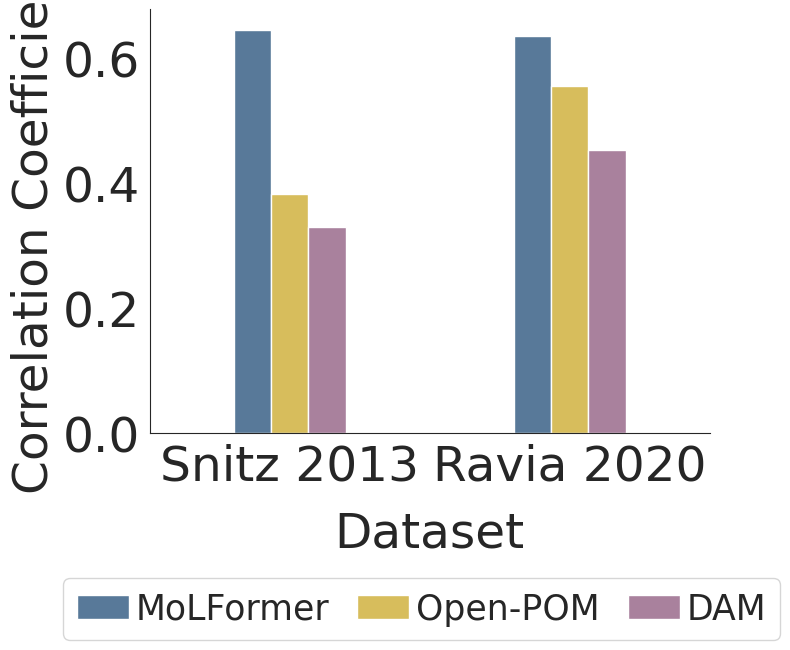

In [54]:
plt.rcParams["font.size"] = 35
data={
    'row_1':  [ "Snitz 2013","MoLFormer",corr_last_snitz],'row_2':["Ravia 2020","MoLFormer" ,corr_last_ravia_similarity],
    'row_3':["Ravia 2020","Open-POM" ,corr_last_ravia_similarity_pom], 'row_4':["Snitz 2013","Open-POM" ,corr_last_snitz_pom],
    'row_5':["Ravia 2020","DAM" ,corr_last_ravia_similarity_alva], 'row_6':["Snitz 2013","DAM" ,corr_last_snitz_alva],
    
    # , "row_3": ["Keller 2016","Raw Representations",corr_last_keller],
    # 'row_4':  [ "Snitz 2013","Transformed Representations",corr_last_linear_snitz],'row_5':["Ravia 2020 ","Transformed Representations" ,corr_last_linear_ravia_similarity] ,'row_3':["Ravia 2020 ","Raw Representations" ,corr_last_ravia_similarity_pom
    
    # , "row_6": ["Keller 2016","Transformed Representations",corr_last_linear_keller]

     }
plot_bars(data,"perception","figs/realign_correlations.pdf")
filename="figs/realign_correlations.pdf"

In [56]:
def plot_lines(data,title,filename):
    df_corrs=pd.DataFrame.from_dict(data, orient='index',
                       columns=['Dataset', 'Correlation'])
    df_corrs=df_corrs.explode('Correlation')
    df_corrs['Layer'] = df_corrs.groupby(level=0).cumcount()
    #alternative
    #df['idx'] = df.groupby(df.index).cumcount()
    df_corrs = df_corrs.reset_index(drop=True)
    sns.set_style("white")
    # df[['0', '1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11']] = df['All layers'].str.split(' ', expand=True)
    fig, ax = plt.subplots(figsize=(10,10)
                           # ,constrained_layout = True
                          )
    
    
    # sns.color_palette("tab10")
    sns.color_palette("hls", 4)
    palette=['#4d79a4','#ecc947','#b07aa0']
    g=sns.lineplot(data=df_corrs, x="Layer", y="Correlation",hue="Dataset",palette = palette, lw=7)
    # sns.barplot(df_corrs, x="Dataset", y="Correlation", hue= "Correlation",width=0.2,legend=False,palette=sns.color_palette("Set2",4))
    
    
    ax.legend().set_title(title)
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
     # axes = plt.gca() #Getting the current axis
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #56c4c0fb
    
    fig.subplots_adjust(bottom=0.35,left=0.2)
    fig.legend(handles, labels, ncol=3, columnspacing=1, prop={'size': 25}, handlelength=1.5, loc="lower center",
               borderpad=0.4,
               
               bbox_to_anchor=(0.54, 0.07), 
               
               frameon=True, labelspacing=0.4,handletextpad=0.2)
    g.set_xticks([0,2,4,6,8,10]) # <--- set the ticks first
    g.set_xticklabels(['1', '3', '5', '7', '9', '11'])
    
    # g.set_yticks([0.45,0.5,0.55,0.6,0.65,0.7]) # <--- set the ticks first
    # g.set_yticklabels(['', '0.5','', '0.6','', '0.7'])
    
    # g.set_yticks([0.45,0.5,0.55,0.6,0.65,0.7]) # <--- set the ticks first
    # g.set_yticklabels(['', '0.5','', '0.6','', '0.7'])
    # g.set_ylim(0.45,0.7)
    
    g.set_xlim(0,11)
    ax.set_ylabel('')
    ax.set_xlabel('Model Layer')
    # plt.margins(0,-0.16)
    ax.xaxis.set_label_coords(0.5, -0.18)
    
    # plt.tight_layout()
    plt.savefig(filename
                , bbox_inches="tight"
               
               )


/tmp/ipykernel_2112207/3060447985.py:19: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g=sns.lineplot(data=df_corrs, x="Layer", y="Correlation",hue="Dataset",palette = palette, lw=7)


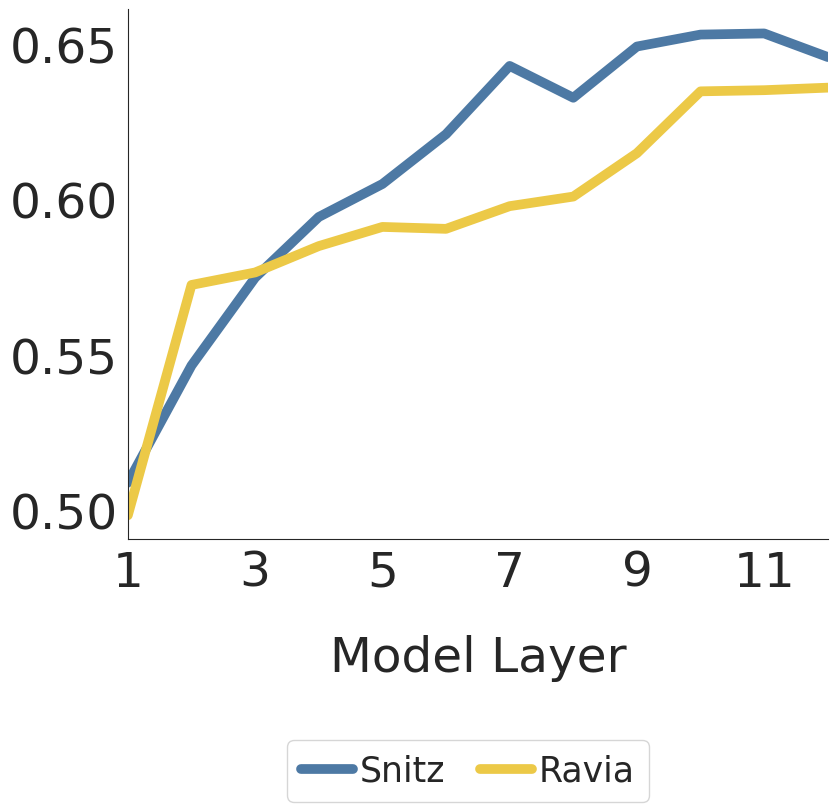

In [57]:
plt.rcParams["font.size"] = 35   
data={'row_1':  [ "Snitz",corr_layers_snitz],'row_2':["Ravia" ,corr_layers_ravia_similarity] 
     # , "row_4": ["Keller 2016",corr_layers_keller]
     }
plot_lines(data,"perception","figs/realign_layers.pdf")